In [1]:
import os
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from PIL import Image
import torch
import tqdm
import platform
import shutil

In [2]:
# Michelle
data_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/"
model_prefix = "/media/nvme1/mitquach/ucsc-cse-244-a-2024-fall-final-project/models/"
if platform.node() == 'navi': # Daniel
    data_prefix = "/home/argon/Stuff/CSE244A_project/"
    model_prefix = "/home/argon/Stuff/CSE244A_project/models/"

In [3]:
categories = pd.read_csv(os.path.join(data_prefix, 'categories.csv'))
train_labels = pd.read_csv(os.path.join(data_prefix, 'train_labeled.csv'))

In [4]:
# Define a dataset class for labeled images
class LabeledImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        label = self.data.iloc[idx, 1]  # Assuming the label is in the second column

        if self.transform:
            image = self.transform(image)

        return image, label

# Define a dataset class for unlabeled images
class UnlabeledImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [os.path.join(root_dir, img) for img in os.listdir(root_dir)]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        idx = int(idx)
        img_name = self.image_paths[idx]
        image = Image.open(img_name).convert("RGB")
        
        if self.transform:
            image = self.transform(image)

        return image  # No label returned

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Adjust mean and std as needed
])

In [7]:
# Initialize datasets
labeled_dataset = LabeledImageDataset(csv_file=os.path.join(data_prefix,'train_labeled.csv'), root_dir=os.path.join(data_prefix,'train/labeled'), transform=transform)
unlabeled_dataset = UnlabeledImageDataset(root_dir=os.path.join(data_prefix,'train/unlabeled'), transform=transform)

# Training / validation split
val_ratio = 0.1
batch_size = 32

val_size = int(val_ratio * len(labeled_dataset))
train_size = len(labeled_dataset) - val_size

generator1 = torch.Generator().manual_seed(12341234)
# Generate as indices so we can save them if needed, but I'm not doing that yet - Daniel
val_idx, train_idx = torch.utils.data.random_split(torch.arange(len(labeled_dataset)), [val_size, train_size], generator=generator1)
train =  torch.utils.data.Subset(labeled_dataset, train_idx)
val =  torch.utils.data.Subset(labeled_dataset, val_idx)

labeled_train_data = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
labeled_val_data = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)


Labeled images:


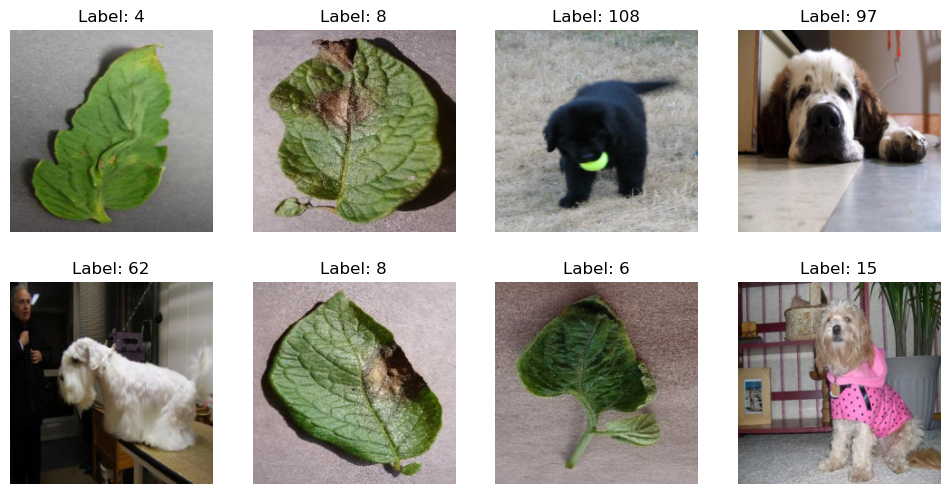

In [8]:
import matplotlib.pyplot as plt

# Function to display a batch of labeled images with labels
def show_labeled_batch(data_loader):
    images, labels = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = img/2 + 0.5 # This roughly un-normalizes them back to a valid range for imshow - Daniel
        plt.imshow(img)
        plt.title(f'Label: {labels[idx].item()}')
        plt.axis('off')
    plt.show()

# Function to display a batch of unlabeled images
def show_unlabeled_batch(data_loader):
    images = next(iter(data_loader))
    plt.figure(figsize=(12, 6))
    for idx in range(min(8, len(images))):
        plt.subplot(2, 4, idx + 1)
        img = images[idx].permute(1, 2, 0) # Convert from Tensor format
        img = img/2 + 0.5 # This roughly un-normalizes them back to a valid range for imshow - Daniel
        plt.imshow(img)
        plt.title("Unlabeled Image")
        plt.axis('off')
    plt.show()

# Display a batch of labeled images
print("Labeled images:")
show_labeled_batch(labeled_train_data)
enumerate(labeled_train_data) # Reset the dataloader https://stackoverflow.com/questions/60311307/how-does-one-reset-the-dataloader-in-pytorch
pass

# # Display a batch of unlabeled images
# print("Unlabeled images:")
# show_unlabeled_batch(unlabeled_loader)


In [9]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

Using cache found in /home/argon/.cache/torch/hub/facebookresearch_deit_main
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/mnt/stuff/argon/conda/mla_miniforge/envs/cse244a_project/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWa

In [10]:
# Modify the final layer to match the number of classes
num_classes = len(categories)  # Adjust to the actual number of classes
model.head = nn.Linear(model.head.in_features, num_classes)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
def save_checkpoint(checkpoint_path, epoch, model, optimizer, scheduler):
    checkpoint_dict = {
        "epoch":epoch,
        "optimizer_dict":optimizer.state_dict(),
        "model_dict":model.state_dict(),
        }

    if scheduler:
        checkpoint_dict["scheduler"] = scheduler.state_dict()

    torch.save(checkpoint_dict, checkpoint_path)

def load_checkpoint(checkpoint_path, model, optimizer, scheduler, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_dict"])
    if scheduler:
        scheduler.load_state_dict(checkpoint["scheduler_dict"])
    return checkpoint["epoch"]

In [13]:
model_path = os.path.join(model_prefix, "michelle_diet")
os.makedirs(model_path, exist_ok=True)

In [14]:
num_epochs = 15  # Adjust as needed

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

start_epoch = 0
checkpoint_path = os.path.join(model_path, f"checkpoint.pth")
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, None, device=device)

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    model.train()
    for images, labels in tqdm.tqdm(labeled_train_data, desc=f"Train ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track statistics
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for images, labels in tqdm.tqdm(labeled_val_data, desc=f"Validation ({epoch+1}/{num_epochs})"):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Track statistics
        val_loss += loss.item()
        _, predicted = outputs.max(1)
        val_total += labels.size(0)
        val_correct += predicted.eq(labels).sum().item()

    save_checkpoint(os.path.join(model_path, f"checkpoint-{epoch}.pth"), epoch + 1, model, optimizer, None)
    shutil.copyfile(os.path.join(model_path, f"checkpoint-{epoch}.pth"), os.path.join(model_path, f"checkpoint.pth"))
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/train_total:.4f}, Val Loss: {val_loss/val_total:.4f}")
    print(f"      Train Accuracy: {100 * train_correct / train_total:.2f}%, Val Accuracy: {100 * val_correct / val_total:.2f}%")


Validation (1/15): 100%|██████████| 31/31 [00:01<00:00, 19.64it/s]


Epoch [1/15], Train Loss: 0.1186, Val Loss: 0.1031
      Train Accuracy: 12.26%, Val Accuracy: 24.16%


Validation (2/15): 100%|██████████| 31/31 [00:01<00:00, 20.49it/s]


Epoch [2/15], Train Loss: 0.0973, Val Loss: 0.0927
      Train Accuracy: 28.75%, Val Accuracy: 30.96%


Train (3/15):  67%|██████▋   | 187/278 [00:26<00:12,  7.01it/s]